### import python library

In [1]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sklearn.neighbors
import sklearn
import phenograph
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import random
from copy import deepcopy
import pickle
import os

import seaborn as sns


import argparse
import pandas as pd
import os
import scanpy as sc
from sklearn.metrics.cluster import adjusted_rand_score
# from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
import cv2
import torchvision.transforms as transforms
from utils import Cal_Spatial_Net, Stats_Spatial_Net, seed_everything
# from train_transformer import train_img, test_img

from transModel import TransImg
import torch
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

from torch_geometric.data import Data

import phenograph
from sklearn.manifold import TSNE
from tqdm import tqdm
import torch.nn.functional as F
import random
import sklearn
import seaborn as sns

### set up Python and R Path

In [2]:
os.environ['R_HOME'] = '/opt/R/4.0.2/lib/R'
os.environ['R_USER'] = '~/anaconda3/lib/python3.8/site-packages/rpy2'
os.environ['LD_LIBRARY_PATH'] = '/opt/R/4.0.2/lib/R/lib'
os.environ['PYTHONHASHSEED'] = '1234'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'


### generate simulation data
1. Spatial_cluster: A tuple, number of domains. Each domain we will assign a dominated cell type
2. Spatial_samples: A tuple, number of dominated cell
3. Noise_cluster: An integer, number of other cell types
4. ratio: A float, the ratio of noise cell types in each domain
5. spa_regions: A list, domain coordinates range for each domain. We are using rectangle for each domain
6. mix_regions: A list, the coordinate range for noise cell types.
7. add_noise_area: A list, the index of mix_region in the spa_regions
8. gene_feat: the dimension for final gene input
9. img_feat: the dimension for image input
10. gene_latent: the latent dimension for gene expression
11. img_latent: the latent dimension for img
12. Sigma_gene: sigma to generate gaussian noise for gene expression in dominated cell types
13. Sigma_img: sigma to generate gaussian noise for image in dominated cell types
14. dropout_gene: dropout rate for gene expression in dominated cell types
15. dropout_img: dropout rate for image in dominated cell types
16. noise_sigma_gene: sigma to generate gaussian noise for gene expression in noise cell types
17. noise_sigma_img: sigma to generate gaussian noise for image in noise cell types
18. noise_dropout_gene: dropout rate for gene expression in noise cell types
19. noise_dropout_img: dropout rate for image in noise cell types
20. name: saved name for pickle
21. seed: fix random seed

In [3]:
# spatial_clusters = (0,4)
dominate_clusters = (0,4)
noise_cluster = (4,9)
spatial_samples = 1000
ratio = 0.3
spa_regions = [
        ((10, 240),(10, 240)),
        ((10, 240),(260, 490)),
        ((260,490),(10, 240)),
        ((260,490),(260,490))
]
mix_regions = [
        ((10, 240), (10, 240)),
        ((10, 240), (10, 240)),
        ((260, 490), (10, 240)),
        ((260, 490), (10, 240)),
        ((10, 240), (260, 490))
]
add_noise_area = [0,0,2,2,1]
gene_feat=500
img_feat=500
gene_latent=30
img_latent=30
sigma_gene=0.5
sigma_img=0.5
dropout_gene=0.4
dropout_img=0.4
noise_sigma_gene=0.5
noise_sigma_img=0.5
noise_dropout_gene=0.3
noise_dropout_img=0.3
seed=1
name=1

import generate data function

In [4]:
def run_pca_feat(data, label_type='cell_cluster'):
    data_a = data['gene_data_dropout']
    data_b = data['img_data_dropout']
    label_true = data[label_type]
    
    gene_feat = PCA(n_components=30).fit_transform(data_a)
    img_feat = PCA(n_components=30).fit_transform(data_b)
    
    my_cmap = sns.color_palette('muted', as_cmap=True)
    
    colors = []
    for cid in data[label_type]:
        colors.append(my_cmap[cid])
        
     # gene
    pred1, _, _ = phenograph.cluster(gene_feat)
    plt.figure(figsize=(17, 5))
    plt.subplot(1, 3, 1)
    X_embedded = TSNE(n_components=2).fit_transform(gene_feat)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors)
    plt.title('gene, ARI = %01.3f' % adjusted_rand_score(label_true, pred1))

    ## img
    pred2, _, _ = phenograph.cluster(img_feat)

    plt.subplot(1, 3, 2)
    X_embedded = TSNE(n_components=2).fit_transform(img_feat)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors)
    plt.title('img, ARI = %01.3f' % adjusted_rand_score(label_true, pred2))

In [5]:
prior = []
name = str(seed) + '_' + str(dropout_gene)

for i in range(noise_cluster[1] - noise_cluster[0]):
    if i % 2 == 0:
        # generate offset with relative large distance
        offset1, offset2 = np.random.uniform(0, 0.1, size=1), np.random.uniform(0.4, 0.5, size=1)
    else:
        # generate offset with relative small distance
        offset1, offset2 = np.random.uniform(0, 0.1, size=1), np.random.uniform(0, 0.1, size=1)
    prior.append([offset1, offset2])


import generation function

In [6]:
from simulate_sigra import gen_data

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8932538032531738 seconds
Jaccard graph constructed in 1.9764108657836914 seconds
Wrote graph to binary file in 0.0433194637298584 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.602895
After 6 runs, maximum modularity is Q = 0.604279
Louvain completed 26 runs in 1.3926713466644287 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 5.390970230102539 seconds


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.711148738861084 seconds
Jaccard graph constructed in 1.9627857208251953 seconds
Wrote graph to binary file in 0.041158199310302734 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.627411
Louvain completed 21 runs in 1.1004407405853271 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 4.882761001586914 seconds


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3297586441040039 seconds
Jaccard graph constructed in 1.196690559387207 seconds
Wrote graph to binary file in 0.01199030876159668 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.291386
After 3 runs, maximum modularity is Q = 0.293291
After 5 runs, maximum modularity is Q = 0.294887
Louvain completed 25 runs in 1.0959789752960205 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.6919162273406982 seconds


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.23979449272155762 seconds
Jaccard graph constructed in 1.3250014781951904 seconds
Wrote graph to binary file in 0.011320829391479492 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.480326
Louvain completed 21 runs in 0.780125617980957 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.470447063446045 seconds


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8811142444610596 seconds
Jaccard graph constructed in 2.5732598304748535 seconds
Wrote graph to binary file in 0.05570578575134277 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.603281
After 2 runs, maximum modularity is Q = 0.616179
After 3 runs, maximum modularity is Q = 0.617757
Louvain completed 23 runs in 1.5500600337982178 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 6.217304944992065 seconds


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8107483386993408 seconds
Jaccard graph constructed in 2.588209629058838 seconds
Wrote graph to binary file in 0.049732208251953125 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.674662
After 5 runs, maximum modularity is Q = 0.67591
Louvain completed 25 runs in 1.4854769706726074 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 5.972713470458984 seconds


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


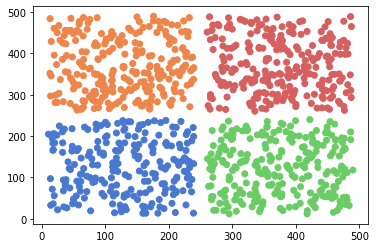

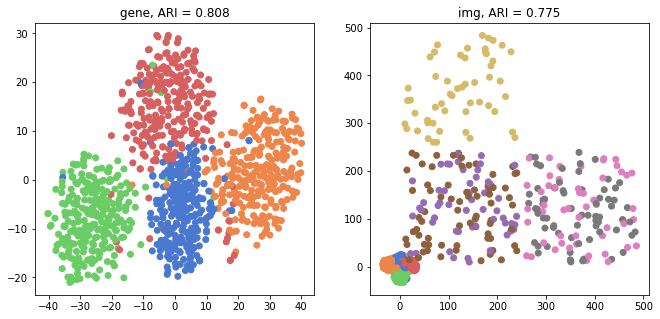

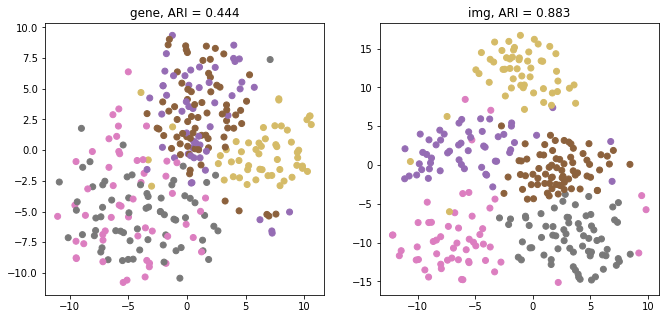

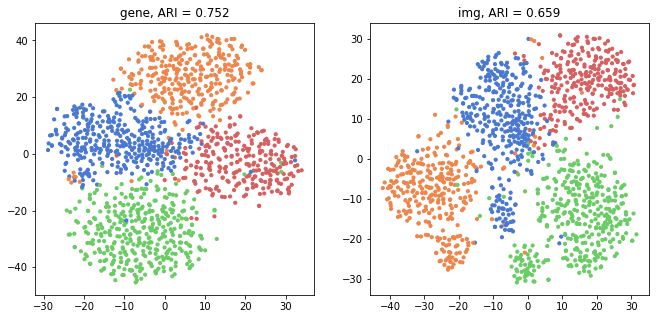

In [7]:
gen_data(
    spatial_cluster=dominate_clusters, 
    mixed_cluster=noise_cluster,
    spatial_samples = spatial_samples,
    ratio=ratio,
    spa_regions = spa_regions,
    mixed_regions = mix_regions,
    prior = prior,
    add_noise_area = add_noise_area,
    gene_feat=gene_feat, 
    img_feat=img_feat,
    gene_latent=gene_latent, 
    img_latent=img_latent,
    sigma_gene=sigma_gene, 
    sigma_img=sigma_img, 
    dropout_gene=dropout_gene, 
    dropout_img=dropout_img,
    noise_sigma_gene=noise_sigma_gene, 
    noise_sigma_img=noise_sigma_img, 
    noise_dropout_gene=noise_dropout_gene, 
    noise_dropout_img=noise_dropout_img,
    seed=seed, 
    name=name
)

run sigra_model

In [8]:
from simulate_sigra import run_sigra_model

In [9]:
sigra_pred, sigra_emb = run_sigra_model('simulation/', 'spatial%s'%(name), n_epochs=800, hidden_dims=[512, 30], seed=seed, lambda_1=0.5, lambda_2=0.5, lambda_3=1.0, graph_type='spatial', gt_type='domain')

spatial1_0.4
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9796957969665527 seconds
Jaccard graph constructed in 2.867751359939575 seconds
Wrote graph to binary file in 0.06324386596679688 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.304572
After 2 runs, maximum modularity is Q = 0.308664
Louvain completed 22 runs in 1.468132734298706 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 6.4916157722473145 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9729118347167969 seconds
Jaccard graph constructed in 2.482731342315674 seconds
Wrote graph to binary file in 0.08352112770080566 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.345034
After 3 runs, maximum modularity is Q = 0.347103
After 5 runs, maximum modularity is Q = 0.349118
After 12 runs, maximum modularity is Q = 

100%|█████████████████████████████████████████| 800/800 [01:00<00:00, 13.21it/s]


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.963550329208374 seconds
Jaccard graph constructed in 3.078958749771118 seconds
Wrote graph to binary file in 0.04755210876464844 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.683691
After 3 runs, maximum modularity is Q = 0.68481
Louvain completed 23 runs in 3.527712345123291 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 9.474424362182617 seconds
spatial1_0.4 0.7443


save embeding and predictionto csv

In [10]:
from simulate_sigra import save_method_pred

In [11]:
emb_df = pd.DataFrame(sigra_emb)
emb_df.to_csv('simulation_results/sigra_emb_spatial%s.csv'%(str(name)))
save_method_pred('simulation_results/spatial%s.csv'%(str(name)), sigra_pred, 'sigra')

calc ari

In [12]:
csv = pd.read_csv('simulation_results/spatial%s.csv'%(str(name)), header=0, index_col=0)
print(csv)

      label_domain  label_cell  gene_pca  img_pca  sigra
0                2           2         0        1      0
1                1           1         1        2      1
2                2           2         0        0      0
3                2           2         0        0      5
4                0           0         3        3      2
...            ...         ...       ...      ...    ...
1295             0           4         3        5      2
1296             0           5         3        3      2
1297             1           8         1        6      1
1298             2           7         0        0      0
1299             2           6         0        5      0

[1300 rows x 5 columns]


In [13]:
from sklearn.metrics.cluster import adjusted_rand_score
ari = adjusted_rand_score(csv['label_domain'], csv['sigra'])
print("ari: %.2f"%(ari))

ari: 0.74
